In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

In [3]:
def read_df(group, tags, samples):
    dfs = []
    for tag in tags:
        for sample in range(samples):
            try:
                df = pd.read_json(f"outputs/{group}/{tag}_{sample}/logs.json")
                df["tag"] = tag
                df["sample"] = sample
                df["epoch"] = df.index
                dfs.append(df)
            except:
                pass
    return pd.concat(dfs)

def agg_df(df_src, s):
    df_list = []
    for c in s:
        df = df_src.copy()
        df["tag"] = df["tag"].apply(lambda s: f"p{c}" if c in s else f"n{c}")
        df = df.groupby(["tag", "epoch"]).mean().reset_index().set_index("epoch")
        df_list.append(df)
    return pd.concat(df_list)
def outer(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def std(m1, m2):
    return (m2.diagonal() - m1.square()).clip(min=0).sqrt()

def cov(m1, m2):
    return m2 - outer(m1)

def corr(m1, m2):
    return cov(m1, m2) / outer(std(m1, m2))

def lin_map(x, s):
    return x.clamp(-s, s), (-s, s)

def inf_map(x, s):
    a = np.pi / 2
    return (x / s * a).arctan() / a, (-1, 1)

def read_state(state, i, sign):
    suffix = "p" if sign else ""
    s0 = state[f"{i}.train_agg.s0"]
    s1 = state[f"{i}.train_agg.s1{suffix}"]
    s2 = state[f"{i}.train_agg.s2{suffix}"]
    return s1 / s0, s2 / s0

def read_weight(state, i, flip):
    w = state[f"{i}.weight"]
    if flip:
        w = w.T
    return w.mean(0), w.T @ w

In [28]:
#group, tags = "schemes", [f"{s}_{l}" for s in ("none", "base", "mean", "cov-mc", "cov-quad", "lin-apx") for l in ("all",)]
group, tags = "schemes", [
    f"cov-quad-b0{o}{l}_all" for o in ("-o0", "-o1", "") for l in ("", "-l1")]
#group, tags = "lin-apx", ("lin-apx_0", "lin-apx_0.5", "lin-apx_1.0", "lin-apx_1.5")
#group, tags = "l2s", ("l2s_0", "l2s_1e-4", "l2s_5e-5", "l2s_2e-5", "l2s_1e-5", "l2s_5e-6")
#group, tags = "l2w", ("l2w_0", "l2w_5e-2", "l2w_2e-2", "l2w_1e-2", "l2w_5e-3", "l2w_2e-3")
#group, tags = "layers", ("l", "l1", "l2", "l12", "l3", "l13", "l23", "l123")
#group, tags = "mix", ("l123_a", "l123_a0", "l123_a1", "l123_a01", "l123_a2", "l123_a02", "l123_a12", "l123_a012")
#group, tags = "mix", ("l_a", "l_a0", "l_a1", "l_a01", "l_a2", "l_a02", "l_a12", "l_a012")
#group, tags = "mix", ("l_a", "l123_a", "l_a012", "l123_a012")
'''group, tags = "mixtures", [
    f"{dl}_{dt}_{al}_{at}"
    for at in ("relu",)# "tanh")
    for al in ("a012",)
    for dl in ("d", "d2", "d123")
    for dt in ("ds", "dw")
    if dl != "d" or dt != "dw"
    if al != "a" or at != "relu"
]'''

samples = 10
epochs = (50,)
tags_epochs = [(tag, epoch) for tag in tags for epoch in epochs]
layers = [f"layer {i+1}" for i in range(3)]

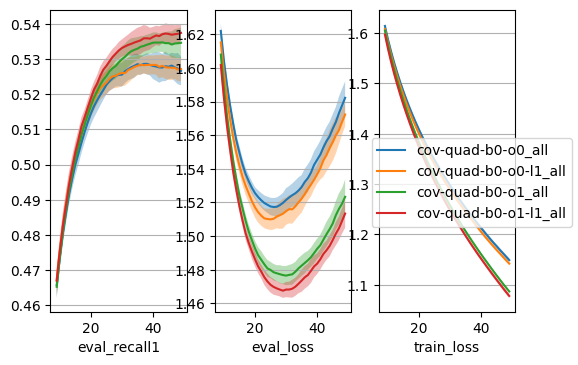

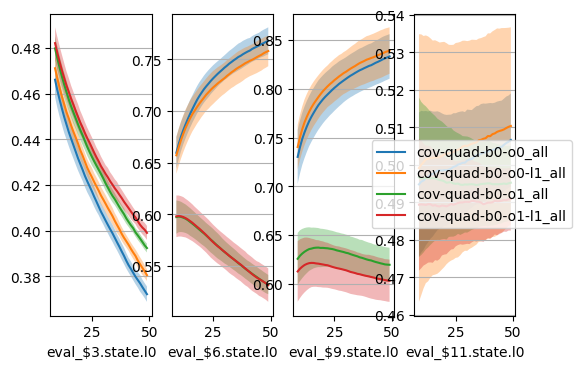

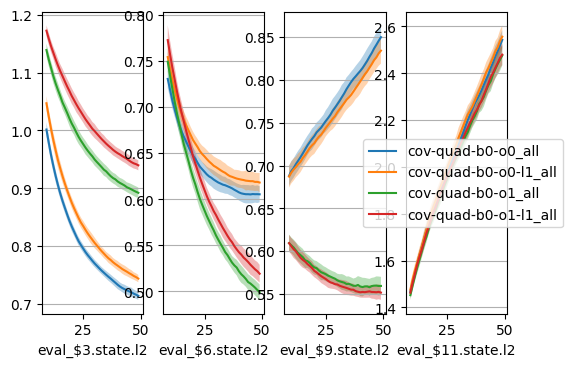

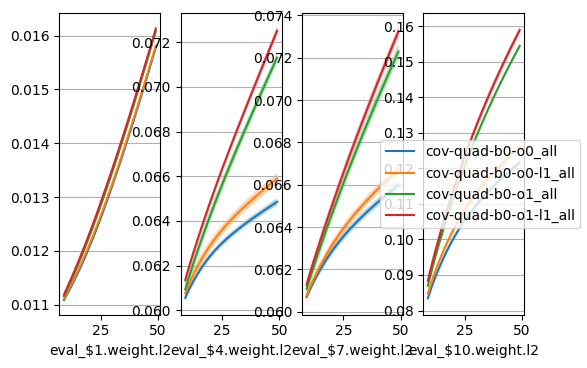

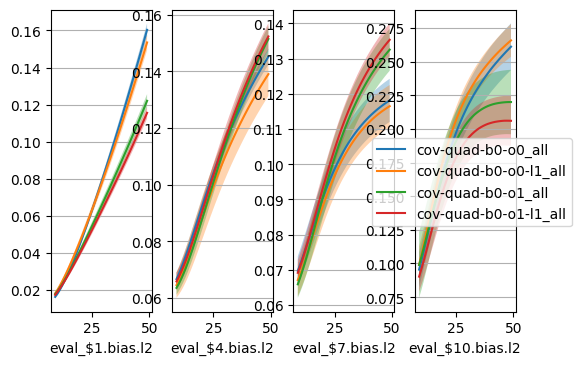

In [29]:
def rowplots(df, labels, start=5, stop=50, sharex=True, sharey=False):
    fig, axes = plt.subplots(
        1, len(labels),
        sharex=sharex, sharey=sharey, 
        facecolor="w", dpi=100)
    if len(labels) == 1:
        axes = [axes]
    df = df[(df.index >= start)&(df.index < stop)]
    df_mean = df.groupby(["tag", "epoch"], sort=False).mean().reset_index().set_index("epoch").groupby("tag", sort=False)
    df_std = df.groupby(["tag", "epoch"], sort=False).std().reset_index().set_index("epoch").groupby("tag", sort=False)
    for ax, label in zip(axes, labels):
        ax.set_xlabel(label)
        ax.grid(axis="y")
        for (tag, mean), (_, std) in zip(df_mean[label], df_std[label]):
            mean = mean.rolling(5).mean()
            std = std.rolling(5).mean()
            ax.plot(mean, label=tag)
            ax.fill_between(mean.index, mean-std, mean+std, alpha=0.33)
    fig.legend(*axes[0].get_legend_handles_labels(), "right")

df = read_df(group, tags, samples)
#df = agg_df(df, "012")
rowplots(df, ["eval_recall1", "eval_loss", "train_loss"])
rowplots(df, [f"eval_${i}.state.l0" for i in (3, 6, 9, 11)])
rowplots(df, [f"eval_${i}.state.l2" for i in (3, 6, 9, 11)])
rowplots(df, [f"eval_${i}.weight.l2" for i in (1, 4, 7, 10)])
rowplots(df, [f"eval_${i}.bias.l2" for i in (1, 4, 7, 10)])
None

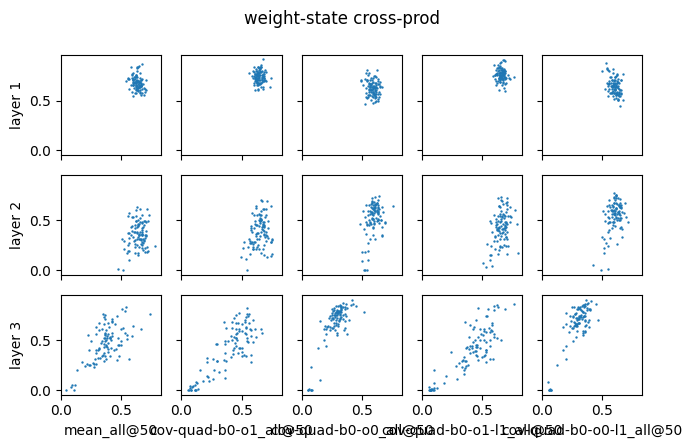

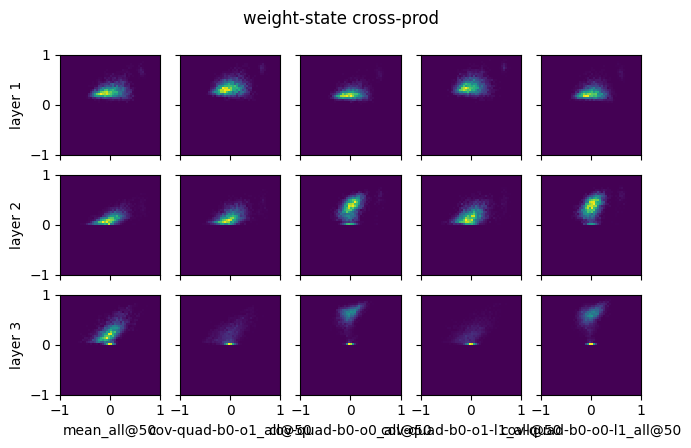

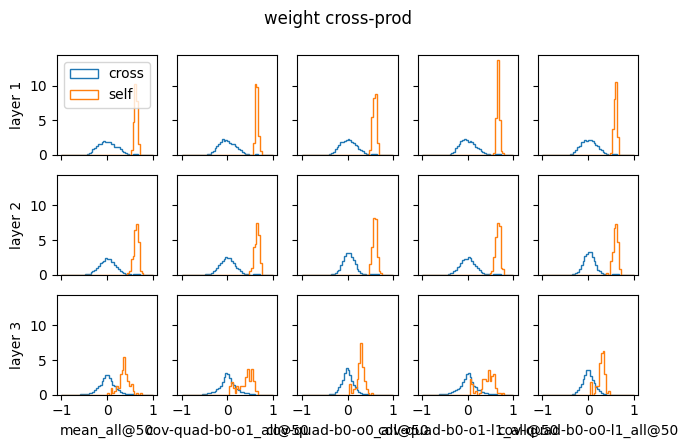

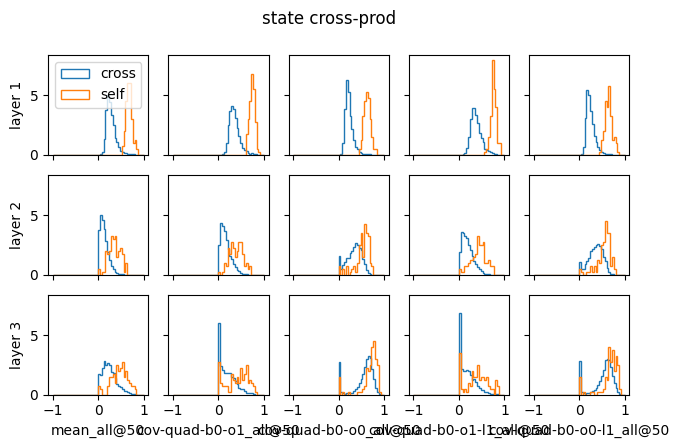

In [6]:
def gridplot(title, xlabels, ylabels):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(
        nrows, ncols, sharex=True, sharey=True, 
        figsize=(ncols*1.5, nrows*1.5), dpi=100, facecolor="w")
    fig.suptitle(title)
    for i in range(ncols):
        axes[nrows-1][i].set_xlabel(xlabels[i])
    for i in range(nrows):
        axes[i][0].set_ylabel(ylabels[i])
    return axes

def hist2d_plot(ax1, ax2, x, y, range, bins):
    ax2.hist2d(x.flatten().numpy(), y.flatten().numpy(), range=range, bins=bins, density=True)
    ax1.scatter(x.diagonal().numpy(), y.diagonal().numpy(), s=0.5)

def hist1d_plot(ax, x, range, bins):
    ax.hist(x.flatten().numpy(), label="cross", range=range, bins=bins, histtype="step", density=True)
    ax.hist(x.diagonal().numpy(), label="self", range=range, bins=bins, histtype="step", density=True)

def setplot(group, tags_epochs, layers, term, sign, scales, mapping, fn):
    xlabels = [f"{tag}@{epoch}" for tag, epoch in tags_epochs]
    ax_xy1 = gridplot(f"weight-state {term}", xlabels, layers)
    ax_xy2 = gridplot(f"weight-state {term}", xlabels, layers)
    ax_x = gridplot(f"weight {term}", xlabels, layers)
    ax_y = gridplot(f"state {term}", xlabels, layers)
    for i, (tag, epoch) in enumerate(tags_epochs):
        state = torch.load(f"outputs/{group}/{tag}_0/checkpoint-{epoch}.pt")
        for j, layer in enumerate(layers):
            w_m1, w_m2 = read_weight(state["model"], j*3+4, False)
            s_m1, s_m2 = read_state(state["model"], j*3+3, sign)
            x, x_range = mapping(fn(w_m1, w_m2), scales[0])
            y, y_range = mapping(fn(s_m1, s_m2), scales[1])
            x_bins, y_bins = 50, 50
            hist2d_plot(ax_xy1[j][i], ax_xy2[j][i], x, y, (x_range, y_range), (x_bins, y_bins))
            hist1d_plot(ax_x[j][i], x, x_range, x_bins)
            hist1d_plot(ax_y[j][i], y, y_range, y_bins)
    ax_x[0][0].legend()
    ax_y[0][0].legend()

term, sign, scales, mapping, fn = "cross-prod", False, (.5, .5), inf_map, lambda m1, m2: m2
#term, sign, scales, mapping, fn = "covariance", False, (.5, .5), inf_map, cov
#term, sign, scales, mapping, fn = "correlation", False, (1., 1.), lin_map, corr
setplot(group, tags_epochs, layers, term, sign, scales, mapping, fn)